In [1]:
import numpy as np # --- Librerías base ---
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt # --- Visualización ---
import seaborn as sns
from pyspark.sql import SparkSession # --- Spark (lectura y escritura en Databricks) ---
from sklearn.model_selection import train_test_split, GridSearchCV # --- Preprocesamiento y pipelines ---
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif # --- Selección de características ---
from sklearn.linear_model import LogisticRegression # --- Modelos ---
from sklearn.ensemble import RandomForestClassifier  
from xgboost import XGBClassifier
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, # --- Métricas ---
    classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, log_loss) 
import joblib # --- Persistencia y experimentación ---
import mlflow
import mlflow.sklearn
from sklearn.calibration import CalibratedClassifierCV # --- Calibración ---
import warnings
warnings.filterwarnings("ignore")

In [2]:
ruta = "/home/andres/data/tabla_unificada.csv"  # Ruta dentro del contenedor
df = pd.read_csv(ruta)
pdf = df
print(" Dimensiones: ", pdf.shape)
display(pdf.head())

# --- Nombre de la columna objetivo ---
target_col = "RESULTADO"

# --- Columnas a excluir manualmente ---
otras = ["ALERTA", "ID_ESTUDIANTE", "ID_DOCENTE", 'SECCION', 'N1GLOBAL', 'FACULTAD_PROGRAMA_1', 'DEPARTAMENTO_PROGRAMA_1', 'DEPARTAMENTO', 'SSC', 'CIUDAD', 'SUSPENSION_DISCIPLINARIA', 
         'CREDITO_INTENTADO_GLOBAL', 'CREDITO_APROBADO_GLOBAL', 'SEMESTRES_MATRICULADOS', 'ICFES_2015_TOTAL', 'COLEGIO_ULT_DANE', 'COLEGIO_ULT_NOMBRE', 'COLEGIO_ULT_DEPTO', 'DEMOGR_MINORIA_ETNICA', 
         'MATERIAS_INSCRITAS', 'DOCENTE', 'NORMAL', 'EXPRESS', 'TIPO_FINANCIAMIENTO_ESPECIFICO']
exclude = ["ID_PERSONA", "LOGIN", "NOMBRE_COMPLETO", "PERIODO"] 
N_IP_cols = [c for n in [2,3,4] for c in [f"N{n}PROYECTO", f"N{n}TAREAS", f"N{n}EXAMEN", f"N{n}GLOBAL"]]
pdf.drop(columns=[c for c in N_IP_cols if c in pdf.columns], inplace=True)
manual_exclude = exclude + otras + N_IP_cols

# --- Detectar numéricas y categóricas automáticamente ---
numeric_cols = pdf.select_dtypes(include=["float", "int", "int64", "float64"]).columns.tolist()
categorical_cols = pdf.select_dtypes(include=["object", "category"]).columns.tolist()

# --- Excluir la variable objetivo y columnas manuales ---
numeric_cols = [c for c in numeric_cols if c != target_col and c not in manual_exclude]
categorical_cols = [c for c in categorical_cols if c != target_col and c not in manual_exclude]

# --- Mostrar resultados ---
print(f" Variables numéricas ({len(numeric_cols)}):", numeric_cols)
print(f" Variables categóricas ({len(categorical_cols)}):", categorical_cols)
print(" Variable objetivo:", target_col)

 Dimensiones:  (9528, 70)


,ID_PERSONA,PERIODO,SECCION,N1PROYECTO,N1TAREAS,N1EXAMEN,N1GLOBAL,NUM_INTENTO_IP,GENERO,EDAD,...,TIPO_FINANCIAMIENTO_ESPECIFICO,PANDEMIA,RETIROS_HASTA_FINAL,BAJO_PROMEDIO_2SEM,BAJO_PROMEDIO_3SEM+,FRACCION_SEMESTRE,SEMESTRES_MATRICULADOS_AGRUPADO,ALERTA,ID_ESTUDIANTE,ID_DOCENTE_INT
0,[00 14 5B 89 CD 44 C3 8D B8 8B C6 DA 18 8D 9D ...,202120,32.0,4.75,0.65,3.65,3.79,1.0,MASCULINO,23.0,...,RECURSOS PROPIOS,1,1,0,0,1.0,1,1,1,55
1,[00 15 AC 50 4D 87 25 F5 FC F3 60 93 15 A0 CE ...,202220,18.0,5.00,5.00,5.00,5.00,1.0,FEMENINO,21.0,...,RECURSOS PROPIOS,0,1,0,0,1.0,1,0,2,25
2,[00 1D B2 B7 5D 96 2E FD 8E 01 CF AE 16 9F DA ...,202020,13.0,4.60,5.00,4.55,4.62,1.0,MASCULINO,25.0,...,AUXILIO EDUCATIVO HIJOS EMPLEADOS,1,1,0,0,1.0,8,0,3,22
3,[00 2C B3 9C 9A 67 D2 2C 46 3C 83 FE 72 95 4A ...,202510,42.0,5.00,5.00,3.85,4.42,1.0,FEMENINO,18.0,...,RECURSOS PROPIOS,0,0,0,0,1.0,1,0,4,55
4,[00 34 00 49 B3 B7 62 C9 3B C1 8B BD A7 E6 FE ...,202120,8.0,4.06,5.00,3.85,4.05,2.0,MASCULINO,26.0,...,RECURSOS PROPIOS,1,1,0,0,1.0,8,1,5,6


 Variables numéricas (30): ['N1PROYECTO', 'N1TAREAS', 'N1EXAMEN', 'NUM_INTENTO_IP', 'EDAD', 'CREDITO_PGA_GLOBAL', 'PROMEDIO_GLOBAL', 'SEMESTRES_PERDIDOS', 'PORCENTAJE_CREDITOS_APROBADOS', 'ICFES_2015_LECTURA', 'ICFES_2015_MATEMATICAS', 'ICFES_2015_CNATURALES', 'ICFES_2015_INGLES', 'DEMOGR_ESTRATO', 'CREDITOS_INSCRITOS', 'LUNES', 'MARTES', 'MIERCOLES', 'JUEVES', 'VIERNES', 'SABADO', 'MINUTOS_INICIO_FRANJA', 'NUM_CITAS', 'PANDEMIA', 'RETIROS_HASTA_FINAL', 'BAJO_PROMEDIO_2SEM', 'BAJO_PROMEDIO_3SEM+', 'FRACCION_SEMESTRE', 'SEMESTRES_MATRICULADOS_AGRUPADO', 'ID_DOCENTE_INT']
 Variables categóricas (11): ['GENERO', 'PROGRAMA_1', 'DESC_ESTADO_ACADEMICO', 'DESC_TIPO_ADMISION', 'COLEGIO_ULT_TIPO', 'DEMOGR_ESTADO_CIVIL_PADRES', 'DEMOGR_NIVEL_EDUC_MADRE', 'DEMOGR_NIVEL_EDUC_PADRE', 'DEMOGR_TIPO_VIVIENDA', 'COLEGIO_ULT_REGION', 'TIPO_SECCION']
 Variable objetivo: RESULTADO


In [3]:
pdf = pdf.dropna(subset=[target_col])
display(pdf.head())

# --- Features y target ---
X = pdf[numeric_cols + categorical_cols]
y = pdf[target_col]

# --- Análisis de distribución antes de decidir ---
print("\n Distribución de resultados académicos:")
distribucion_resultados = pdf[target_col].value_counts()
print(distribucion_resultados)
print(f"\nTotal registros: {len(pdf)}")

riesgo_vals = ["reprobado", "retirado", "incompleto", "pendiente disciplinario"]
print(f"✓ Definición FIJA de riesgo (para todo el pipeline): {riesgo_vals}")

# Calcular porcentaje de reprobados
pct_reprobados = (pdf[target_col].str.lower() == 'reprobado').sum() / len(pdf) * 100
print(f"\nPorcentaje de reprobados: {pct_reprobados:.1f}%")

# Recalcular balance con nueva definición
y_bin = y.apply(lambda val: "RIESGO" if str(val).lower() in riesgo_vals else "NO RIESGO")
balance_nuevo = pd.Series(y_bin).value_counts()
ratio_nuevo = balance_nuevo['NO RIESGO'] / balance_nuevo['RIESGO']
print(f"\n Nuevo balance de clases:")
print(f"  NO RIESGO: {balance_nuevo['NO RIESGO']} ({balance_nuevo['NO RIESGO']/len(pdf)*100:.1f}%)")
print(f"  RIESGO: {balance_nuevo['RIESGO']} ({balance_nuevo['RIESGO']/len(pdf)*100:.1f}%)")
print(f"  Ratio: {ratio_nuevo:.2f}:1")

# --- Codificar etiquetas ---
le = LabelEncoder()
y_enc = le.fit_transform(y_bin)

# --- Análisis de balance de clases ---
print("\n--- ANÁLISIS DE DESBALANCEO ---")
class_counts = pd.Series(y_enc).value_counts()
total = len(y_enc)
print(f"Clase NO RIESGO (0): {class_counts[0]} ({class_counts[0]/total*100:.2f}%)")
print(f"Clase RIESGO (1): {class_counts[1]} ({class_counts[1]/total*100:.2f}%)")
print(f"Ratio desbalanceo: {class_counts[0]/class_counts[1]:.2f}:1")

# --- Decisión de Equipo: Si el desbalanceo es mayor a 3:1, aplicar estrategia ---
if class_counts[0]/class_counts[1] > 3:
    print("\n ALERTA: Desbalanceo significativo detectado, Considerar SMOTE, undersampling o ajustar class_weight")
   
    # Opción 1: Calcular peso óptimo para XGBoost
    scale_pos_weight = class_counts[0] / class_counts[1]
    print(f"scale_pos_weight sugerido para XGBoost: {scale_pos_weight:.2f}")

    # Opción 2: Sugerir ampliar definición de riesgo
    print("\n Considera ampliar 'riesgo_vals' para incluir más categorías:")
else:
    scale_pos_weight = 1.0
    print("\n✓ Balance de clases aceptable")

print(f" Target codificado: 0=NO RIESGO, 1=RIESGO")

,ID_PERSONA,PERIODO,SECCION,N1PROYECTO,N1TAREAS,N1EXAMEN,N1GLOBAL,NUM_INTENTO_IP,GENERO,EDAD,...,TIPO_FINANCIAMIENTO_ESPECIFICO,PANDEMIA,RETIROS_HASTA_FINAL,BAJO_PROMEDIO_2SEM,BAJO_PROMEDIO_3SEM+,FRACCION_SEMESTRE,SEMESTRES_MATRICULADOS_AGRUPADO,ALERTA,ID_ESTUDIANTE,ID_DOCENTE_INT
0,[00 14 5B 89 CD 44 C3 8D B8 8B C6 DA 18 8D 9D ...,202120,32.0,4.75,0.65,3.65,3.79,1.0,MASCULINO,23.0,...,RECURSOS PROPIOS,1,1,0,0,1.0,1,1,1,55
1,[00 15 AC 50 4D 87 25 F5 FC F3 60 93 15 A0 CE ...,202220,18.0,5.00,5.00,5.00,5.00,1.0,FEMENINO,21.0,...,RECURSOS PROPIOS,0,1,0,0,1.0,1,0,2,25
2,[00 1D B2 B7 5D 96 2E FD 8E 01 CF AE 16 9F DA ...,202020,13.0,4.60,5.00,4.55,4.62,1.0,MASCULINO,25.0,...,AUXILIO EDUCATIVO HIJOS EMPLEADOS,1,1,0,0,1.0,8,0,3,22
3,[00 2C B3 9C 9A 67 D2 2C 46 3C 83 FE 72 95 4A ...,202510,42.0,5.00,5.00,3.85,4.42,1.0,FEMENINO,18.0,...,RECURSOS PROPIOS,0,0,0,0,1.0,1,0,4,55
4,[00 34 00 49 B3 B7 62 C9 3B C1 8B BD A7 E6 FE ...,202120,8.0,4.06,5.00,3.85,4.05,2.0,MASCULINO,26.0,...,RECURSOS PROPIOS,1,1,0,0,1.0,8,1,5,6



 Distribución de resultados académicos:
RESULTADO
APROBADO                   6359
RETIRADO                   2184
REPROBADO                   962
INCOMPLETO                   18
PENDIENTE DISCIPLINARIO       5
Name: count, dtype: int64

Total registros: 9528
✓ Definición FIJA de riesgo (para todo el pipeline): ['reprobado', 'retirado', 'incompleto', 'pendiente disciplinario']

Porcentaje de reprobados: 10.1%

 Nuevo balance de clases:
  NO RIESGO: 6359 (66.7%)
  RIESGO: 3169 (33.3%)
  Ratio: 2.01:1

--- ANÁLISIS DE DESBALANCEO ---
Clase NO RIESGO (0): 6359 (66.74%)
Clase RIESGO (1): 3169 (33.26%)
Ratio desbalanceo: 2.01:1

✓ Balance de clases aceptable
 Target codificado: 0=NO RIESGO, 1=RIESGO


In [4]:

# Imputación de datos para evitar errores en SelectKBest
X_imputed = X.copy()
for col in numeric_cols:
    X_imputed[col] = SimpleImputer(strategy="median").fit_transform(X_imputed[[col]])[:, 0]
for col in categorical_cols:
    X_imputed[col] = SimpleImputer(strategy="most_frequent").fit_transform(X_imputed[[col]])[:, 0]
    # Codificar categóricas para Chi2
    X_imputed[col] = LabelEncoder().fit_transform(X_imputed[col])

# --- Selección de variables ---
# Separar numéricas y categóricas para aplicar el test correcto
X_num = X_imputed[numeric_cols]
X_cat = X_imputed[categorical_cols]

# Test ANOVA para numéricas
selector_num = SelectKBest(score_func=f_classif, k="all")
selector_num.fit(X_num, y_enc)
p_values_num = pd.Series(selector_num.pvalues_, index=numeric_cols)
numeric_cols = p_values_num[p_values_num < 0.05].index.tolist()

# Test Chi2 para categóricas
selector_cat = SelectKBest(score_func=chi2, k="all")
selector_cat.fit(X_cat, y_enc)
p_values_cat = pd.Series(selector_cat.pvalues_, index=categorical_cols)
categorical_cols = p_values_cat[p_values_cat < 0.05].index.tolist()

# --- Reporte de variables seleccionadas y descartadas ---
all_features = numeric_cols + categorical_cols
selected_features = numeric_cols + categorical_cols
discarded_features = [f for f in X.columns if f not in selected_features]

# --- Ranking completo ---
print("\n Ranking ANOVA (todas las numéricas):")
for col, p in sorted(p_values_num.items(), key=lambda x: x[1]):
    print(f"{col:35s}  p-value={p:.5f}")

print("\n Ranking Chi2 (todas las categóricas):")
for col, p in sorted(p_values_cat.items(), key=lambda x: x[1]):
    print(f"{col:35s}  p-value={p:.5f}")

print(" --- Reporte de Selección de Variables: ---")
print(f"Total de variables antes de selección: {len(X.columns)}")
print(f"Variables seleccionadas (p < 0.05): {len(selected_features)}")
print(f"Variables descartadas (p >= 0.05): {len(discarded_features)}")
print("-" * 40)
print(" Variables Numéricas Seleccionadas:", numeric_cols)
print(" Variables Categóricas Seleccionadas:", categorical_cols)
print(" Variables Descartadas:", discarded_features)


 Ranking ANOVA (todas las numéricas):
N1TAREAS                             p-value=0.00000
N1EXAMEN                             p-value=0.00000
N1PROYECTO                           p-value=0.00000
ICFES_2015_MATEMATICAS               p-value=0.00000
PORCENTAJE_CREDITOS_APROBADOS        p-value=0.00000
ICFES_2015_INGLES                    p-value=0.00000
ICFES_2015_CNATURALES                p-value=0.00000
ICFES_2015_LECTURA                   p-value=0.00000
PROMEDIO_GLOBAL                      p-value=0.00000
SEMESTRES_PERDIDOS                   p-value=0.00000
NUM_INTENTO_IP                       p-value=0.00000
BAJO_PROMEDIO_3SEM+                  p-value=0.00000
EDAD                                 p-value=0.00000
BAJO_PROMEDIO_2SEM                   p-value=0.00000
SEMESTRES_MATRICULADOS_AGRUPADO      p-value=0.00000
CREDITO_PGA_GLOBAL                   p-value=0.00001
CREDITOS_INSCRITOS                   p-value=0.00001
DEMOGR_ESTRATO                       p-value=0.00007
NUM_CIT

In [5]:

# --- Split clásico ---
def split_clasico(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

# --- Split por periodos ---
def split_periodos(pdf, numeric_cols, categorical_cols, target_col):
    periodos = sorted(pdf["PERIODO"].unique())
    print(f" Se encontraron {len(periodos)} periodos distintos")
    for i in range(len(periodos) - 1):
        periodo_train = periodos[:i+1] # Toma todos los periodos excepto el último
        periodo_test = [periodos[i+1]]

        train_data = pdf[pdf["PERIODO"].isin(periodo_train)]
        test_data  = pdf[pdf["PERIODO"].isin(periodo_test)]

        X_train = train_data[numeric_cols + categorical_cols]
        y_train = train_data[target_col].apply(lambda val: 1 if str(val).lower() in riesgo_vals else 0)

        X_test = test_data[numeric_cols + categorical_cols]
        y_test = test_data[target_col].apply(lambda val: 1 if str(val).lower() in riesgo_vals else 0)

        yield X_train, X_test, y_train, y_test, periodo_train, periodo_test[0]

In [6]:
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, label="", param_grid=None):
       
    # 1. Definir preprocesador
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

    # 2. Crear pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor), 
        ("clf", modelo)
    ])
    
    # 3. Optimización de hiperparámetros (si se proporciona grid)
    if param_grid:
        print(f" GridSearchCV para {label}...")
        try:
            search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)
            search.fit(X_train, y_train)
            pipeline = search.best_estimator_  # Ya entrenado
            print(f"  ✓ Mejores params: {search.best_params_}")
            
        except Exception as e:
            print(f"  GridSearch falló: {e}. Usando config por defecto.")
            pipeline.fit(X_train, y_train)
    else:
        # Sin grid, entrenamiento directo
        pipeline.fit(X_train, y_train)

    # 4. Predicción y optimización de umbral
    try:
        if not hasattr(pipeline, "predict_proba"):
            print(f"  Modelo sin predict_proba. Usando predicción directa.")
            y_pred = pipeline.predict(X_test)
            metrics = {
                "recall": recall_score(y_test, y_pred, zero_division=0),
                "precision": precision_score(y_test, y_pred, zero_division=0),
                "f1": f1_score(y_test, y_pred, zero_division=0),
                "accuracy": accuracy_score(y_test, y_pred),
                "umbral_optimo": 0.5,
                "roc_auc": None
            }
            return metrics
        
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
        # Verificar que hay ambas clases
        if len(set(y_test)) < 2:
            return {"warning": "Solo una clase en test set"}
        
        # --- Optimizar umbral buscando mejor F1-Score ---
        mejor_umbral = 0.5
        mejor_f1 = 0
        umbrales_candidatos = np.arange(0.1, 0.9, 0.05)
        
        for umbral in umbrales_candidatos:
            y_pred_temp = (y_prob >= umbral).astype(int)
            f1_temp = f1_score(y_test, y_pred_temp, zero_division=0)
            
            if f1_temp > mejor_f1:
                mejor_f1 = f1_temp
                mejor_umbral = umbral
        
        # Predicción final con mejor umbral
        y_pred = (y_prob >= mejor_umbral).astype(int)
        
        # Calcular todas las métricas
        metrics = {
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "accuracy": accuracy_score(y_test, y_pred),
            "umbral_optimo": mejor_umbral,
            "roc_auc": roc_auc_score(y_test, y_prob)
        }
        
        # Logging conciso
        print(f"  {label} | F1={metrics['f1']:.3f} | "
              f"Recall={metrics['recall']:.3f} | "
              f"Precision={metrics['precision']:.3f} | "
              f"Umbral={metrics['umbral_optimo']:.2f}")
        
        return metrics
        
    except Exception as e:
        print(f" Error en evaluación de {label}: {e}")
        return {"warning": f"Error: {e}"}

In [7]:
X_final = pdf[numeric_cols + categorical_cols]
y_final = pdf[target_col].apply(lambda val: 1 if str(val).lower() in riesgo_vals else 0)

print(" --- Dataset final preparado ---")
print("X_final:", X_final.shape, "| y_final:", y_final.shape)
print(" *** Distribución de clases en el target final: *** ")
print(y_final.value_counts(normalize=True))

num_negativos = sum(y_final == 0)
num_positivos = sum(y_final == 1)
scale_pos_weight = num_negativos / num_positivos
print("scale_pos_weight:", scale_pos_weight)

# --- Modelos candidatos con balance de clases ---
modelos_candidatos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, eval_metric="logloss", scale_pos_weight=scale_pos_weight
    )
}

# Grid para todos los modelos
param_grid_logreg = {'clf__C': [0.1, 1.0, 10.0], 'clf__penalty': ['l2', 'l1']}
param_grid_rf = {'clf__n_estimators': [150, 250], 'clf__max_depth': [8, 12]}
param_grid_xgb = {'clf__n_estimators': [200, 300, 400],'clf__learning_rate': [0.03, 0.05, 0.1],'clf__max_depth': [4, 6, 8],
                  'clf__min_child_weight': [1, 3],'clf__subsample': [0.7, 0.8],'clf__colsample_bytree': [0.7, 0.8],'clf__gamma': [0, 0.1]} 

#param_grid_xgb = {'clf__n_estimators': [200, 300], 'clf__learning_rate': [0.1, 0.05], 'clf__max_depth': [4, 6]}

print(f" Grid Search con {len(param_grid_xgb)} parámetros")
print(f"   Combinaciones totales: {np.prod([len(v) for v in param_grid_xgb.values()])}")

# Diccionario que mapea nombres de modelos a sus grids
modelos_grids = { 
    "Regresión Logística": param_grid_logreg, 
    "Random Forest": param_grid_rf,
    "XGBoost": param_grid_xgb
}

# --- Evaluar múltiples modelos ---
resultados = []

# --- Evaluación clásica ---
try:
    X_train, X_test, y_train, y_test = split_clasico(X_final, y_final, test_size=0.2)
    print("\n *** Split clásico *** ")
    
    for nombre, modelo in modelos_candidatos.items():
        if len(set(y_train)) > 1 and len(set(y_test)) > 1:
            grid = modelos_grids.get(nombre) # Creación del mejor grid
            metrics = evaluar_modelo(modelo, X_train, X_test, y_train, y_test, label=f"Clásico | {nombre}", param_grid=grid)
            metrics["modelo"] = nombre
            metrics["split"] = "clásico"
            resultados.append(metrics)
        else:
            print(f" {nombre} no evaluado en split clásico (solo una clase en train/test)")
            resultados.append({
                "modelo": nombre,
                "split": "clásico",
                "warning": " Solo una clase presente en train/test"
            })
except Exception as e:
    print(f" Error en split clásico: {e}")

# --- Evaluación por periodos ---
splits_periodos = split_periodos(pdf, numeric_cols, categorical_cols, target_col)

for X_train, X_test, y_train, y_test, train_periods, test_period in splits_periodos:
    print(f"\n Entrenamiento con {len(train_periods)} periodos ({', '.join(map(str, train_periods))})")
    print(f" → Prueba en el periodo: {test_period}")
    
    for nombre, modelo in modelos_candidatos.items():
        if len(set(y_train)) > 1 and len(set(y_test)) > 1:
            grid = modelos_grids.get(nombre) #Grid de validación temporal
            metrics = evaluar_modelo(modelo, X_train, X_test, y_train, y_test, label=f"Periodo {train_periods[-1]} → {test_period} | {nombre}", param_grid=grid)
            metrics["modelo"] = nombre
            metrics["split"] = f"{train_periods[-1]}→{test_period}"
            resultados.append(metrics)
        else:
            print(f" {nombre} no evaluado en periodo {train_periods[-1]}→{test_period} (solo una clase en train/test)")
            resultados.append({
                "modelo": nombre,
                "split": f"{train_periods[-1]}→{test_period}",
                "warning": " Solo una clase presente en train/test"
            })

# --- Consolidar resultados ---
df_resultados = pd.DataFrame(resultados)
cols_order = ["modelo", "split", "recall", "precision", "f1", "roc_auc", "accuracy"]
df_resultados = df_resultados[[c for c in cols_order if c in df_resultados.columns] + [c for c in df_resultados.columns if c not in cols_order]]

print("\n Evaluación completada (Clásico + Periodos)")
display(df_resultados)

# --- Selección basada en métrica de negocio ---
best_model_name = None
best_umbral = None
best_metric_value = 0

print("\n Definiendo criterio de selección de modelo:")
print("Opciones disponibles:")
print("  1. F1-Score (balance precision-recall)")
print("  2. Recall (minimizar falsos negativos)")
print("  3. Precision (minimizar falsas alarmas)")
print("  4. Custom (ej: 2*precision + recall)")

# --- Decisión de equipo para ajustar variable objetivo ---
metrica_objetivo = "f1"  # Cambiar a recall? 
peso_precision = 0.6  # Solo para modo "custom"
peso_recall = 0.4

print(f"\n✓ Métrica seleccionada: {metrica_objetivo.upper()}")

try:
    df_metricas = df_resultados.dropna(subset=[metrica_objetivo])
    
    if metrica_objetivo == "custom":
        # Crear métrica custom
        df_metricas["score_custom"] = (
            peso_precision * df_metricas["precision"] + 
            peso_recall * df_metricas["recall"]
        )
        best_row = df_metricas.loc[df_metricas["score_custom"].idxmax()]
        best_metric_value = best_row["score_custom"]
    else:
        best_row = df_metricas.loc[df_metricas[metrica_objetivo].idxmax()]
        best_metric_value = best_row[metrica_objetivo]
    
    best_model_name = best_row["modelo"]
    best_umbral = best_row["umbral_optimo"]
    
    print(f"\n MEJOR MODELO: {best_model_name}")
    print(f"   {metrica_objetivo.upper()}: {best_metric_value:.4f}")
    print(f"   Recall: {best_row['recall']:.4f}")
    print(f"   Precision: {best_row['precision']:.4f}")
    print(f"   F1-Score: {best_row['f1']:.4f}")
    print(f"   Umbral óptimo: {best_umbral:.2f}")
    print(f"   Split: {best_row['split']}")
    
    # --- Validación de calidad ---
    if best_row['precision'] < 0.5 and best_row['recall'] > 0.8:
        print("\n ALERTA DE CALIDAD:")
        print("   El modelo tiene alta tasa de falsos positivos.")
        print("   Recomendaciones:")
        print("   - Revisar definición de 'riesgo_vals'")
        print("   - Ajustar umbral hacia valores mayores (ej: 0.6-0.7)")
        print("   - Aplicar técnicas de balanceo de clases")
    
except Exception as e:
    print(f" Error al seleccionar modelo: {e}")
    best_model_name = None

 --- Dataset final preparado ---
X_final: (9528, 31) | y_final: (9528,)
 *** Distribución de clases en el target final: *** 
RESULTADO
0    0.667401
1    0.332599
Name: proportion, dtype: float64
scale_pos_weight: 2.0066266961186496
 Grid Search con 7 parámetros
   Combinaciones totales: 432

 *** Split clásico *** 
 GridSearchCV para Clásico | Regresión Logística...
  ✓ Mejores params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
  Clásico | Regresión Logística | F1=0.680 | Recall=0.715 | Precision=0.649 | Umbral=0.50
 GridSearchCV para Clásico | Random Forest...
  ✓ Mejores params: {'clf__max_depth': 8, 'clf__n_estimators': 250}
  Clásico | Random Forest | F1=0.679 | Recall=0.767 | Precision=0.610 | Umbral=0.45
 GridSearchCV para Clásico | XGBoost...
  ✓ Mejores params: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.03, 'clf__max_depth': 4, 'clf__min_child_weight': 3, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
  Clásico | XGBoost | F1=0.687 | Recall=0.729 | Pr

,modelo,split,recall,precision,f1,roc_auc,accuracy,umbral_optimo
0,Regresión Logística,clásico,0.714511,0.648997,0.680180,0.843287,0.776495,0.50
1,Random Forest,clásico,0.766562,0.609787,0.679245,0.842809,0.759182,0.45
2,XGBoost,clásico,0.728707,0.649789,0.686989,0.846329,0.779119,0.50
3,Regresión Logística,202020→202110,0.765273,0.607143,0.677098,0.811336,0.760296,0.55
4,Random Forest,202020→202110,0.819936,0.544872,0.654685,0.809890,0.715945,0.40
5,XGBoost,202020→202110,0.774920,0.577938,0.662088,0.808050,0.740232,0.55
6,Regresión Logística,202110→202120,0.788520,0.534836,0.637363,0.781932,0.668527,0.30
7,Random Forest,202110→202120,0.655589,0.673913,0.664625,0.800412,0.755580,0.40
8,XGBoost,202110→202120,0.664653,0.647059,0.655738,0.793904,0.742188,0.35
9,Regresión Logística,202120→202210,0.821727,0.603272,0.695755,0.816283,0.721683,0.35



 Definiendo criterio de selección de modelo:
Opciones disponibles:
  1. F1-Score (balance precision-recall)
  2. Recall (minimizar falsos negativos)
  3. Precision (minimizar falsas alarmas)
  4. Custom (ej: 2*precision + recall)

✓ Métrica seleccionada: F1

 MEJOR MODELO: Random Forest
   F1: 0.7124
   Recall: 0.6936
   Precision: 0.7324
   F1-Score: 0.7124
   Umbral óptimo: 0.45
   Split: 202120→202210


 Se encontraron 10 periodos distintos
 Se encontraron 10 periodos distintos
 Se encontraron 10 periodos distintos


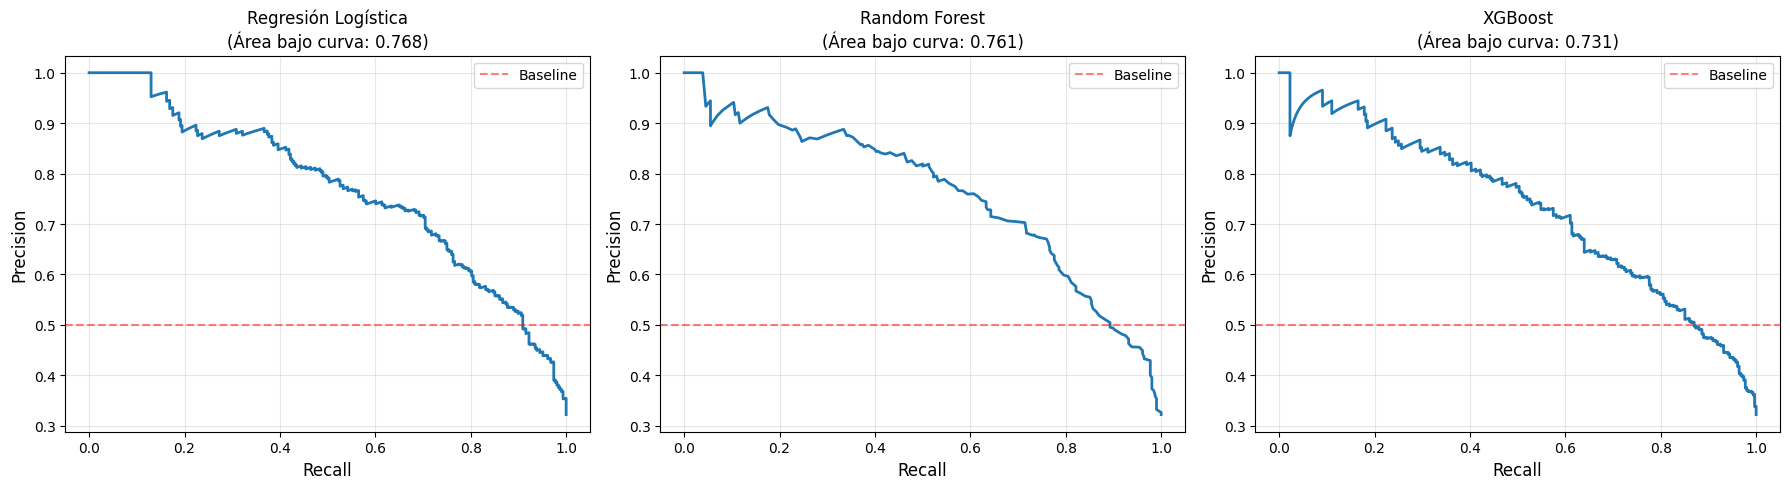

 Se encontraron 10 periodos distintos


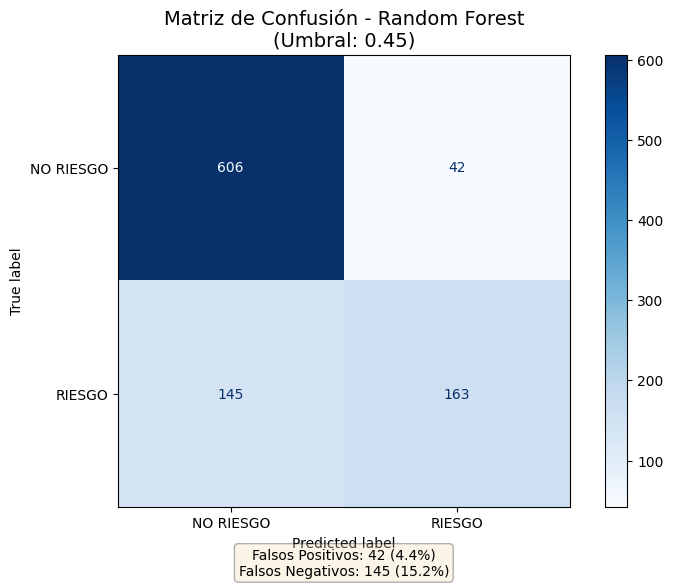

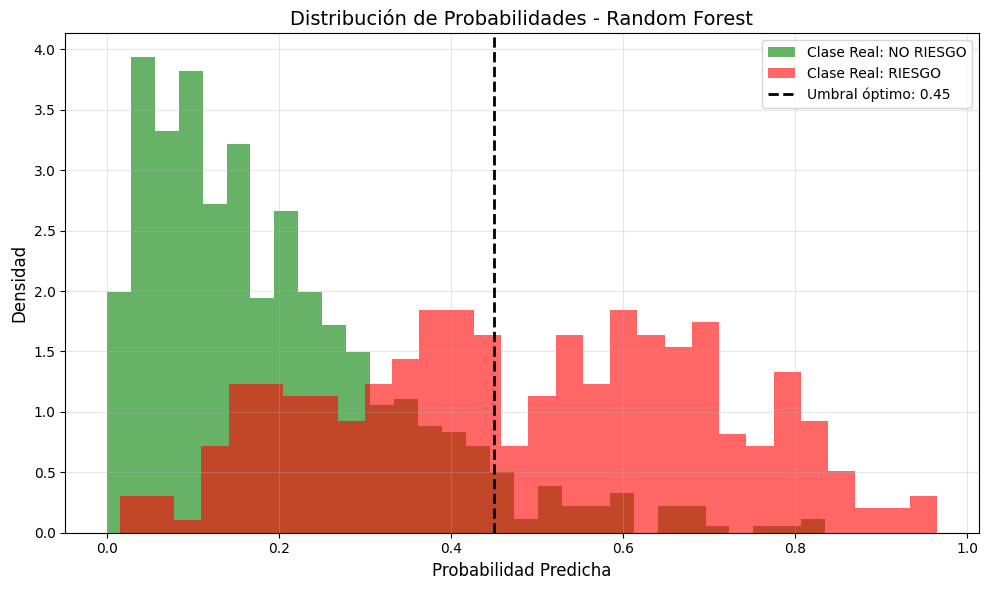


 ANÁLISIS DE SEPARABILIDAD DE CLASES:
Media prob. NO RIESGO: 0.196 (std: 0.152)
Media prob. RIESGO: 0.486 (std: 0.218)
Separación (diferencia de medias): 0.289
 ALERTA: Baja separabilidad entre clases. El modelo tiene dificultad para distinguirlas.
   Recomendación: Feature engineering o recolección de más variables discriminativas.


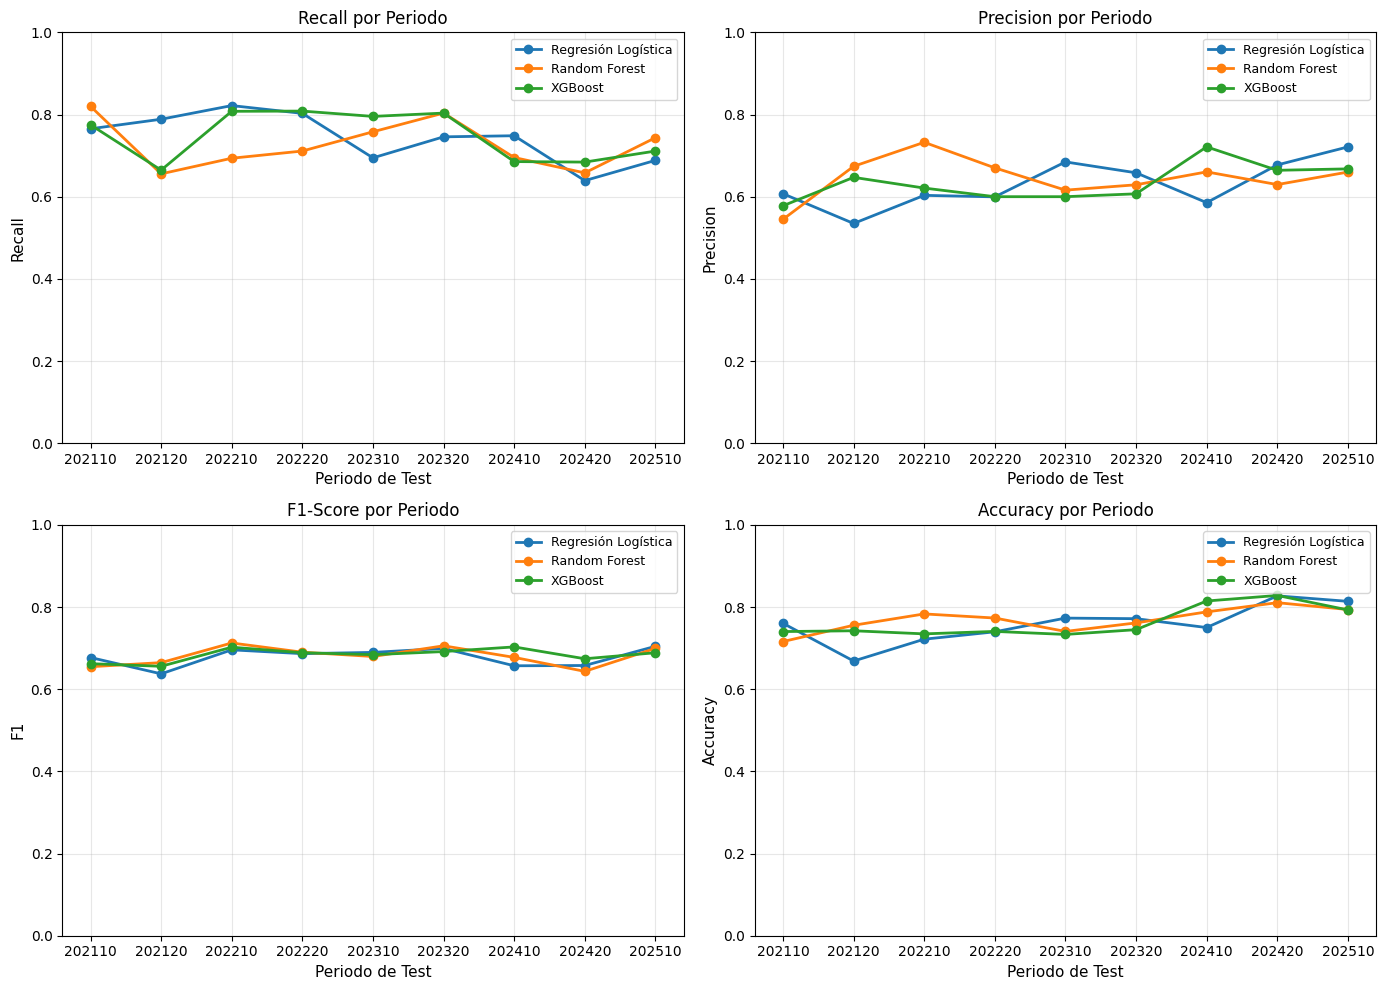


 ANÁLISIS DE ESTABILIDAD TEMPORAL:
Regresión Logística: Desviación std F1 = 0.023 ✓ Estable
Random Forest: Desviación std F1 = 0.023 ✓ Estable
XGBoost: Desviación std F1 = 0.016 ✓ Estable

 TOP 15 FEATURES MÁS IMPORTANTES (Random Forest):


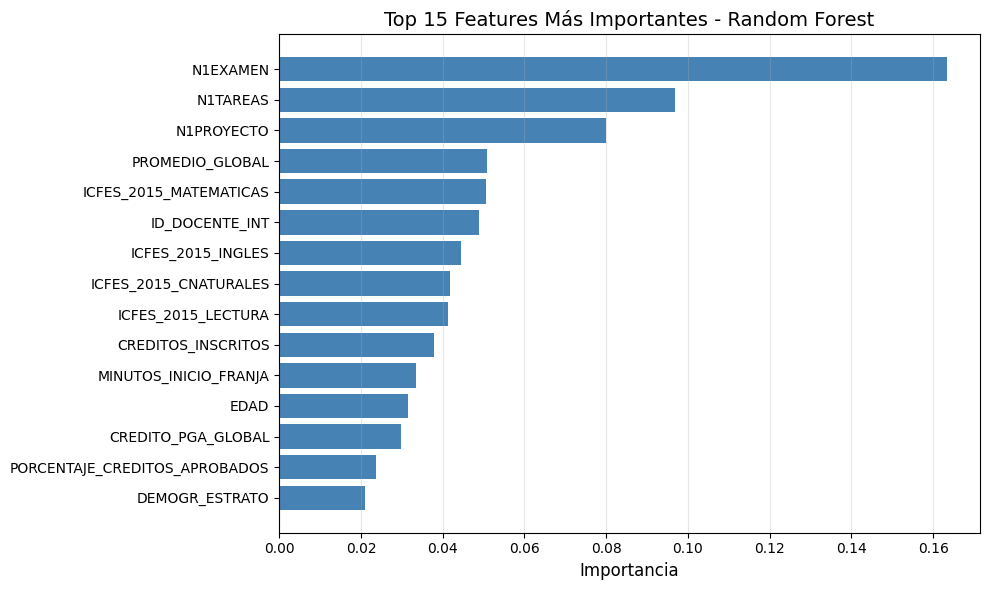


TOP 5 Features:
  N1EXAMEN: 0.1633
  N1TAREAS: 0.0969
  N1PROYECTO: 0.0800
  PROMEDIO_GLOBAL: 0.0509
  ICFES_2015_MATEMATICAS: 0.0506


In [8]:
# 1. Curva Precision-Recall por modelo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (nombre, modelo) in enumerate(modelos_candidatos.items()):
    
    # Usar el último split temporal
    X_train, X_test, y_train, y_test = list(split_periodos(pdf, numeric_cols, categorical_cols, target_col))[-1][:4]
    
    # Entrenar y predecir
    preprocessor = ColumnTransformer(transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols)
    ])
    pipeline = Pipeline([("preprocessor", preprocessor), ("clf", modelo)])
    pipeline.fit(X_train, y_train)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Calcular curva
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    
    # Graficar
    axes[idx].plot(recall, precision, linewidth=2)
    axes[idx].set_xlabel('Recall', fontsize=12)
    axes[idx].set_ylabel('Precision', fontsize=12)
    axes[idx].set_title(f'{nombre}\n(Área bajo curva: {auc(recall, precision):.3f})', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(0.5, color='r', linestyle='--', alpha=0.5, label='Baseline')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# 2. Matriz de confusión del mejor modelo
if best_model_name:   
    # Obtener predicciones del mejor modelo en el último periodo
    last_split = list(split_periodos(pdf, numeric_cols, categorical_cols, target_col))[-1]
    X_train, X_test, y_train, y_test = last_split[:4]
    
    # Recrear pipeline del mejor modelo
    modelo_final = modelos_candidatos[best_model_name]
    preprocessor = ColumnTransformer(transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols)
    ])
    pipeline_viz = Pipeline([("preprocessor", preprocessor), ("clf", modelo_final)])
    pipeline_viz.fit(X_train, y_train)
    y_prob_viz = pipeline_viz.predict_proba(X_test)[:, 1]
    y_pred_viz = (y_prob_viz >= best_umbral).astype(int)
    
    # Crear matriz
    cm = confusion_matrix(y_test, y_pred_viz)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO RIESGO', 'RIESGO'])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Matriz de Confusión - {best_model_name}\n(Umbral: {best_umbral:.2f})', fontsize=14)
    
    # Añadir anotaciones adicionales
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    ax.text(0.5, -0.15, f'Falsos Positivos: {fp} ({fp/total*100:.1f}%)\nFalsos Negativos: {fn} ({fn/total*100:.1f}%)', 
            transform=ax.transAxes, ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()

# 3. Distribución de probabilidades por clase real
if best_model_name:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Separar por clase real
    riesgo_probs = y_prob_viz[y_test == 1]
    no_riesgo_probs = y_prob_viz[y_test == 0]
    
    ax.hist(no_riesgo_probs, bins=30, alpha=0.6, label='Clase Real: NO RIESGO', color='green', density=True)
    ax.hist(riesgo_probs, bins=30, alpha=0.6, label='Clase Real: RIESGO', color='red', density=True)
    ax.axvline(best_umbral, color='black', linestyle='--', linewidth=2, label=f'Umbral óptimo: {best_umbral:.2f}')
    
    ax.set_xlabel('Probabilidad Predicha', fontsize=12)
    ax.set_ylabel('Densidad', fontsize=12)
    ax.set_title(f'Distribución de Probabilidades - {best_model_name}', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de separabilidad
    print("\n ANÁLISIS DE SEPARABILIDAD DE CLASES:")
    print(f"Media prob. NO RIESGO: {no_riesgo_probs.mean():.3f} (std: {no_riesgo_probs.std():.3f})")
    print(f"Media prob. RIESGO: {riesgo_probs.mean():.3f} (std: {riesgo_probs.std():.3f})")
    print(f"Separación (diferencia de medias): {riesgo_probs.mean() - no_riesgo_probs.mean():.3f}")
    
    if riesgo_probs.mean() - no_riesgo_probs.mean() < 0.3:
        print(" ALERTA: Baja separabilidad entre clases. El modelo tiene dificultad para distinguirlas.")
        print("   Recomendación: Feature engineering o recolección de más variables discriminativas.")

# 4. Evolución de métricas por periodo
if len(df_resultados) > 0:
    # Filtrar solo resultados de validación temporal
    df_temporal = df_resultados[df_resultados['split'].str.contains('→', na=False)].copy()
    
    if len(df_temporal) > 0:
        # Extraer periodo de test
        df_temporal['periodo_test'] = df_temporal['split'].str.split('→').str[-1]
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        metricas = ['recall', 'precision', 'f1', 'accuracy']
        titulos = ['Recall por Periodo', 'Precision por Periodo', 'F1-Score por Periodo', 'Accuracy por Periodo']
        
        for idx, (metrica, titulo) in enumerate(zip(metricas, titulos)):
            ax = axes[idx // 2, idx % 2]
            
            for modelo_nom in df_temporal['modelo'].unique():
                df_modelo = df_temporal[df_temporal['modelo'] == modelo_nom]
                ax.plot(df_modelo['periodo_test'], df_modelo[metrica], marker='o', label=modelo_nom, linewidth=2)
            
            ax.set_xlabel('Periodo de Test', fontsize=11)
            ax.set_ylabel(metrica.capitalize(), fontsize=11)
            ax.set_title(titulo, fontsize=12)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()
        
        print("\n ANÁLISIS DE ESTABILIDAD TEMPORAL:")
        for modelo_nom in df_temporal['modelo'].unique():
            df_modelo = df_temporal[df_temporal['modelo'] == modelo_nom]
            std_f1 = df_modelo['f1'].std()
            print(f"{modelo_nom}: Desviación std F1 = {std_f1:.3f}", end="")
            if std_f1 > 0.1:
                print(" Alta variabilidad entre periodos")
            else:
                print(" ✓ Estable")

# 5. Importancia de features (solo para modelos tree-based)
if best_model_name in ['Random Forest', 'XGBoost']:
    print(f"\n TOP 15 FEATURES MÁS IMPORTANTES ({best_model_name}):")
    
    # Obtener feature importances del último modelo entrenado
    feature_names = numeric_cols + categorical_cols
    
    # Para XGBoost y RF, necesitamos obtener las features después del OneHotEncoding
    # Entrenar un modelo temporal para extraer importancias
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = split_clasico(X_final, y_final)
    
    modelo_temp = modelos_candidatos[best_model_name]
    preprocessor_temp = ColumnTransformer(transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), categorical_cols)
    ])
    
    # Transformar datos
    X_train_processed = preprocessor_temp.fit_transform(X_train_temp)
    
    # Entrenar modelo
    modelo_temp.fit(X_train_processed, y_train_temp)
    
    # Obtener nombres de features después de OneHotEncoding
    feature_names_encoded = []
    
    # Numéricas
    feature_names_encoded.extend(numeric_cols)
    
    # Categóricas (después de OneHotEncoding)
    if categorical_cols:
        encoder = preprocessor_temp.named_transformers_['cat'].named_steps['encoder']
        cat_features = encoder.get_feature_names_out(categorical_cols)
        feature_names_encoded.extend(cat_features)
    
    # Obtener importancias
    importances = modelo_temp.feature_importances_
    
    # Crear DataFrame
    df_importance = pd.DataFrame({
        'feature': feature_names_encoded,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)
    
    # Visualizar
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df_importance['feature'], df_importance['importance'], color='steelblue')
    ax.set_xlabel('Importancia', fontsize=12)
    ax.set_title(f'Top 15 Features Más Importantes - {best_model_name}', fontsize=14)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de features
    print("\nTOP 5 Features:")
    for idx, row in df_importance.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

In [9]:
pipeline_final_calibrado = None 

if best_model_name:
    print(f"\n Calibrando '{best_model_name}' con validación temporal estricta")

    periodos = sorted(pdf["PERIODO"].unique())
    
    # Entrenamiento: Todos menos los últimos 2 periodos
    train_periods_calib = periodos[:-2]
    # Calibración: Penúltimo periodo (NO el último)
    calib_period = periodos[-2]
    # Holdout final: Último periodo (Lo reservamos para predicción)
    holdout_period = periodos[-1]
    
    print(f" Split temporal:")
    print(f"  - Entrenamiento: {train_periods_calib}")
    print(f"  - Calibración: [{calib_period}]")
    print(f"  - Holdout (no usado): [{holdout_period}]")

    # Preparar datos
    train_data_calib = pdf[pdf["PERIODO"].isin(train_periods_calib)]
    calib_data = pdf[pdf["PERIODO"] == calib_period]

    X_calib_train = train_data_calib[numeric_cols + categorical_cols]
    y_calib_train = train_data_calib[target_col].apply(
        lambda val: 1 if str(val).lower() in riesgo_vals else 0
    )
    
    X_calib_test = calib_data[numeric_cols + categorical_cols]
    y_calib_test = calib_data[target_col].apply(
        lambda val: 1 if str(val).lower() in riesgo_vals else 0
    )
    
    # Verificar que hay ambas clases
    if len(set(y_calib_test)) < 2:
        print(" Solo una clase en datos de calibración. Saltando calibración.")
    else:
        # Recrear preprocesador
        numeric_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])
        categorical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ])
        preprocessor_sel = ColumnTransformer(transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ])

        # Entrenar pipeline base
        modelo_base = modelos_candidatos[best_model_name]
        pipeline_base = Pipeline([("preprocessor", preprocessor_sel), ("clf", modelo_base)])
        pipeline_base.fit(X_calib_train, y_calib_train)
        
        # Calibrar con método isotonic (mejor para datasets pequeños)
        calibrator = CalibratedClassifierCV(estimator=pipeline_base, method='sigmoid', cv="prefit")
        calibrator.fit(X_calib_test, y_calib_test)
        pipeline_final_calibrado = calibrator
        print("✓ Calibrador entrenado correctamente")
        
        # Evaluar calibración
        y_prob_before = pipeline_base.predict_proba(X_calib_test)[:, 1]
        y_prob_after = calibrator.predict_proba(X_calib_test)[:, 1]
        
        print(f"\nMejora en calibración:")
        print(f"  Prob. promedio antes: {y_prob_before.mean():.3f}")
        print(f"  Prob. promedio después: {y_prob_after.mean():.3f}")
        print(f"  Tasa real de riesgo: {y_calib_test.mean():.3f}")
else:
    print(" No se pudo calibrar: Mejor modelo no definido")


 Calibrando 'Random Forest' con validación temporal estricta
 Split temporal:
  - Entrenamiento: [202020, 202110, 202120, 202210, 202220, 202310, 202320, 202410]
  - Calibración: [202420]
  - Holdout (no usado): [202510]
✓ Calibrador entrenado correctamente

Mejora en calibración:
  Prob. promedio antes: 0.309
  Prob. promedio después: 0.260
  Tasa real de riesgo: 0.260


In [10]:
!pip install mlflow
import mlflow
import mlflow.sklearn

if 'pipeline_final_calibrado' in locals():
    model_file_name = f"Mejor_modelo_calibrado_{best_model_name.lower().replace(' ', '_')}.pkl"
    mlflow_run_name = f"Modelo_final_{best_model_name.replace(' ', '_')}_Calibrado"
    
    # --- 1. Guardar local con joblib ---
    joblib.dump(pipeline_final_calibrado, model_file_name)
    print(f"✓ Modelo guardado localmente como {model_file_name}")

    # --- 2. Guardar en MLflow ---
    with mlflow.start_run(run_name=mlflow_run_name):
        
        # A. Parámetros del Modelo
        mlflow.log_param("modelo_base", best_model_name)
        mlflow.log_param("umbral_produccion", round(best_umbral, 4))
        mlflow.log_param("metodo_calibracion", "sigmoid")
        
        # Información de periodos
        periodos = sorted(pdf["PERIODO"].unique())
        mlflow.log_param("periodos_train", str(periodos[:-2]))
        mlflow.log_param("periodo_calibracion", str(periodos[-2]))
        mlflow.log_param("periodo_holdout", str(periodos[-1]))
        
        # Balance de clases
        mlflow.log_param("scale_pos_weight", round(scale_pos_weight, 2))
        mlflow.log_param("n_features", len(numeric_cols + categorical_cols))
        
        # B. Métricas de Calibración
        try:
            if 'X_calib' in locals() and 'y_calib' in locals():
                y_prob_calib = pipeline_final_calibrado.predict_proba(X_calib)[:, 1]
                y_pred_calib = (y_prob_calib >= best_umbral).astype(int)
                mlflow.log_metric("calib_f1", f1_score(y_calib, y_pred_calib, zero_division=0))
                mlflow.log_metric("calib_recall", recall_score(y_calib, y_pred_calib, zero_division=0))
                mlflow.log_metric("calib_precision", precision_score(y_calib, y_pred_calib, zero_division=0))
                mlflow.log_metric("calib_roc_auc", roc_auc_score(y_calib, y_prob_calib))
                print(f"✓ Métricas de calibración registradas")
        except Exception as e:
            print(f" Error al calcular métricas de calibración: {e}")
        
        # C. Métricas en Holdout para producción
        try:
            if 'X_holdout' in locals() and 'y_holdout' in locals():
                y_prob_holdout = pipeline_final_calibrado.predict_proba(X_holdout)[:, 1]
                y_pred_holdout = (y_prob_holdout >= best_umbral).astype(int)
                
                mlflow.log_metric("holdout_f1", f1_score(y_holdout, y_pred_holdout, zero_division=0))
                mlflow.log_metric("holdout_recall", recall_score(y_holdout, y_pred_holdout, zero_division=0))
                mlflow.log_metric("holdout_precision", precision_score(y_holdout, y_pred_holdout, zero_division=0))
                mlflow.log_metric("holdout_roc_auc", roc_auc_score(y_holdout, y_prob_holdout))
                
                print(f"✓ Métricas de holdout registradas")
        except Exception as e:
            print(f" Error al calcular métricas de holdout: {e}")
        
        # D. Registrar Modelo
        mlflow.sklearn.log_model(pipeline_final_calibrado, "calibrated_model")
        print(f" Modelo calibrado guardado en MLflow como: {mlflow_run_name}")
else:
    print(" No se pudo guardar: El pipeline calibrado (pipeline_final_calibrado) no está definido.")

✓ Modelo guardado localmente como Mejor_modelo_calibrado_random_forest.pkl


2025/11/01 15:28:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/01 15:29:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modelo calibrado guardado en MLflow como: Modelo_final_Random_Forest_Calibrado


In [11]:
if best_model_name and 'pipeline_final_calibrado' in locals():
    print(f"\n Generando predicciones con {best_model_name} CALIBRADO")

    periodos = sorted(pdf["PERIODO"].unique()) # --- Solo predice sobre el periodo holdout 202510
    holdout_period = periodos[-1]  # Último periodo reservado
    print(f" Prediciendo SOLO sobre periodo holdout: {holdout_period}")
    print("   (Datos históricos NO incluidos para evitar leakage)")
    
    # Filtrar solo el periodo de holdout
    df_holdout = pdf[pdf["PERIODO"] == holdout_period].copy()
    
    if len(df_holdout) == 0:
        print(" No hay datos en periodo holdout. Abortando predicción.")
    else:
        X_holdout = df_holdout[numeric_cols + categorical_cols]
        
        # Predicción con modelo calibrado
        y_prob_holdout = pipeline_final_calibrado.predict_proba(X_holdout)[:, 1]
        y_pred_holdout = (y_prob_holdout >= best_umbral).astype(int)
        
        # Consolidar resultados
        df_holdout["PREDICCION_NUM"] = y_pred_holdout
        df_holdout["PROBABILIDAD_RIESGO"] = y_prob_holdout
        df_holdout["ALERTA"] = df_holdout["PREDICCION_NUM"].apply(
            lambda pred: "RIESGO" if pred == 1 else "NO RIESGO"
        )
        
        # Añadir metadatos del modelo
        df_holdout["MODELO_USADO"] = best_model_name
        df_holdout["UMBRAL_APLICADO"] = best_umbral
        df_holdout["FECHA_PREDICCION"] = pd.Timestamp.now()
        
        # *** Análisis de distribución de predicciones ***
        print(f"\n Resultados en periodo {holdout_period}:")
        print(f"   Total registros: {len(df_holdout)}")
        alertas = df_holdout["ALERTA"].value_counts()
        print(f"   Alertas RIESGO: {alertas.get('RIESGO', 0)} "
              f"({alertas.get('RIESGO', 0)/len(df_holdout)*100:.1f}%)")
        print(f"   Sin riesgo: {alertas.get('NO RIESGO', 0)} "
              f"({alertas.get('NO RIESGO', 0)/len(df_holdout)*100:.1f}%)")
        
        # Si hay ground truth, evaluar
        if target_col in df_holdout.columns:
            y_true = df_holdout[target_col].apply(
                lambda val: 1 if str(val).lower() in riesgo_vals else 0
            )
            
            if len(set(y_true)) > 1:  # Si hay ambas clases
                print(f"\n Métricas en Producción (Holdout):")
                print(f"   Recall: {recall_score(y_true, y_pred_holdout):.3f}")
                print(f"   Precision: {precision_score(y_true, y_pred_holdout):.3f}")
                print(f"   F1-Score: {f1_score(y_true, y_pred_holdout):.3f}")
                print(f"   Accuracy: {accuracy_score(y_true, y_pred_holdout):.3f}")
        
        # Exportar a Delta Lake
        """spark_df_holdout = spark.createDataFrame(df_holdout)
        table_name_final = "ct_ingenieria_prj.stg.tabla_unificada_modelo_v1"
        
        spark_df_holdout.write.format("delta") \
            .mode("overwrite") \
            .option("overwriteSchema", "true") \
            .saveAsTable(table_name_final)"""
        
        #print(f"\n Predicciones exportadas a: {table_name_final}")
        #print(f"   Registros escritos: {spark_df_holdout.count()}")
        
        # Mostrar muestra de predicciones de alto riesgo
        top_riesgo = df_holdout.nlargest(10, "PROBABILIDAD_RIESGO")[
            ["ID_PERSONA", "PROBABILIDAD_RIESGO", "ALERTA", target_col]
        ]
        print("\n Top 10 estudiantes en riesgo:")
        display(top_riesgo)
        
else:
    print(" No se pudo generar predicciones: modelo o calibrador no disponible")


 Generando predicciones con Random Forest CALIBRADO
 Prediciendo SOLO sobre periodo holdout: 202510
   (Datos históricos NO incluidos para evitar leakage)

 Resultados en periodo 202510:
   Total registros: 956
   Alertas RIESGO: 207 (21.7%)
   Sin riesgo: 749 (78.3%)

 Métricas en Producción (Holdout):
   Recall: 0.532
   Precision: 0.792
   F1-Score: 0.637
   Accuracy: 0.804

 Top 10 estudiantes en riesgo:


,ID_PERSONA,PROBABILIDAD_RIESGO,ALERTA,RESULTADO
7784,[2F DD 58 39 13 54 DE 8F 23 72 50 0D 5F 27 4B ...,0.967024,RIESGO,RETIRADO
7907,[33 4B 84 F2 5D 95 C9 F6 0F 84 3C 89 73 51 88 ...,0.963248,RIESGO,RETIRADO
5672,[F8 2D 9D FB D2 72 97 D6 89 60 CF 2A 37 EE 4F ...,0.951042,RIESGO,RETIRADO
472,[0C 34 4D 62 DC 2E E5 13 48 EF 93 B0 97 DF 70 ...,0.949270,RIESGO,REPROBADO
996,[1A 35 66 44 98 82 BB 78 02 4E DD 5D 9F FB BA ...,0.945540,RIESGO,RETIRADO
330,[08 80 71 FD BD F5 9B 71 83 8C DD F7 CF 84 D5 ...,0.935056,RIESGO,RETIRADO
1726,[CE D4 F8 BB 7F 34 2F 29 9F 2E EA AA 5B 69 AC ...,0.930358,RIESGO,REPROBADO
3150,[93 91 FA B0 83 EA ED EE B9 C9 3B FB AB 4D 0E ...,0.927893,RIESGO,RETIRADO
3986,[6B 07 82 C5 6A 5D F0 DA BB CE B0 BC 04 75 C6 ...,0.922719,RIESGO,REPROBADO
5499,[F3 6F C3 28 F1 7C 4C CC C5 36 3A 50 9E D9 67 ...,0.922719,RIESGO,RETIRADO


 IDENTIFICACIÓN DE FACTORES DE RIESGO
Estudiantes en riesgo: 3169
Estudiantes sin riesgo: 6359

 ANÁLISIS DE VARIABLES NUMÉRICAS
------------------------------------------------------------

Top 10 factores numéricos (ordenados por Cohen's d):
                         variable  media_riesgo  media_no_riesgo  cohens_d  \
2                        N1EXAMEN      2.929719         4.171175  1.019400   
1                        N1TAREAS      2.874323         4.467490  0.903837   
0                      N1PROYECTO      3.765210         4.717572  0.697511   
10         ICFES_2015_MATEMATICAS     71.018345        76.097611  0.560079   
8   PORCENTAJE_CREDITOS_APROBADOS      0.860195         0.939882  0.529390   
12              ICFES_2015_INGLES     75.424609        80.344863  0.467557   
11          ICFES_2015_CNATURALES     66.359732        70.167216  0.466628   
9              ICFES_2015_LECTURA     67.754362        70.923410  0.464536   
6                 PROMEDIO_GLOBAL      3.609617       

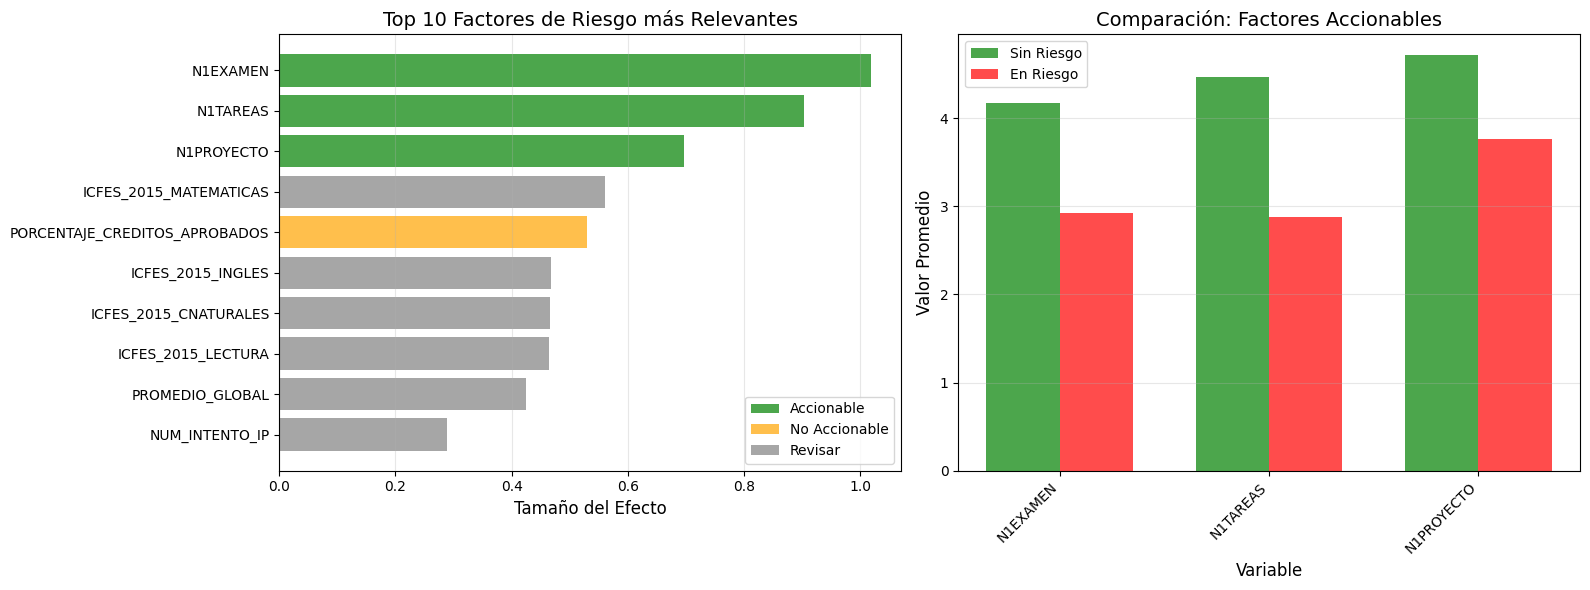


 Análisis de factores de riesgo completado


In [12]:
print(" IDENTIFICACIÓN DE FACTORES DE RIESGO")
print("="*60)

# 1. Preparar datos
df_analisis = pdf.copy()
df_analisis['target_bin'] = df_analisis[target_col].apply(
    lambda val: 1 if str(val).lower() in riesgo_vals else 0
)

# Separar estudiantes en riesgo vs no riesgo
df_riesgo = df_analisis[df_analisis['target_bin'] == 1]
df_no_riesgo = df_analisis[df_analisis['target_bin'] == 0]

print(f"Estudiantes en riesgo: {len(df_riesgo)}")
print(f"Estudiantes sin riesgo: {len(df_no_riesgo)}")

# 2. Análisis de variables numéricas
print("\n ANÁLISIS DE VARIABLES NUMÉRICAS")
print("-"*60)

factores_numericos = []

for col in numeric_cols:
    if col in df_analisis.columns:
        # Calcular estadísticas
        media_riesgo = df_riesgo[col].mean()
        media_no_riesgo = df_no_riesgo[col].mean()
        diferencia = abs(media_riesgo - media_no_riesgo)
        
        # Test estadístico (t-test)
        stat, p_value = stats.ttest_ind(
            df_riesgo[col].dropna(), 
            df_no_riesgo[col].dropna(),
            equal_var=False
        )
        
        # Cohen's d (tamaño del efecto)
        pooled_std = np.sqrt(
            (df_riesgo[col].std()**2 + df_no_riesgo[col].std()**2) / 2
        )
        cohens_d = abs(media_riesgo - media_no_riesgo) / pooled_std if pooled_std > 0 else 0
        
        factores_numericos.append({
            'variable': col,
            'media_riesgo': media_riesgo,
            'media_no_riesgo': media_no_riesgo,
            'diferencia_abs': diferencia,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'significativo': p_value < 0.05
        })

df_factores_num = pd.DataFrame(factores_numericos).sort_values('cohens_d', ascending=False)

# Mostrar top 10
print("\nTop 10 factores numéricos (ordenados por Cohen's d):")
print(df_factores_num.head(10)[['variable', 'media_riesgo', 'media_no_riesgo', 'cohens_d', 'p_value']])

# 3. Análisis de variables categóricas
print("\n\n ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("-"*60)

factores_categoricos = []

for col in categorical_cols:
    if col in df_analisis.columns:
        # Tabla de contingencia
        contingency = pd.crosstab(df_analisis[col], df_analisis['target_bin'])
        
        # Chi-square test
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
        
        # Cramér's V (tamaño del efecto)
        n = contingency.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
        
        # Calcular tasa de riesgo por categoría
        tasas = df_analisis.groupby(col)['target_bin'].agg(['mean', 'count'])
        categoria_max_riesgo = tasas['mean'].idxmax()
        tasa_max = tasas['mean'].max()
        
        factores_categoricos.append({
            'variable': col,
            'chi2': chi2,
            'p_value': p_value,
            'cramers_v': cramers_v,
            'categoria_alto_riesgo': categoria_max_riesgo,
            'tasa_riesgo_max': tasa_max,
            'significativo': p_value < 0.05
        })

df_factores_cat = pd.DataFrame(factores_categoricos).sort_values('cramers_v', ascending=False)

print("\nTop 5 factores categóricos (ordenados por Cramér's V):")
print(df_factores_cat.head(5)[['variable', 'categoria_alto_riesgo', 'tasa_riesgo_max', 'cramers_v', 'p_value']])

# 4. CLASIFICACIÓN: Accionables vs No Accionables
print("\n\n CLASIFICACIÓN DE FACTORES")
print("="*60)

# Definir criterios de accionabilidad
# Un factor es ACCIONABLE si la institución puede intervenir sobre él
accionables_keywords = [
    'asistencia', 'tarea', 'proyecto', 'examen', 'quiz', 'parcial',
    'participacion', 'entrega', 'actividad', 'trabajo', 'practica'
]

no_accionables_keywords = [
    'edad', 'genero', 'estrato', 'procedencia', 'programa', 'semestre',
    'creditos_aprobados', 'pga', 'papa', 'promedio_historico'
]

def clasificar_factor(nombre_variable):
    """Clasifica si un factor es accionable o no"""
    nombre_lower = nombre_variable.lower()
    
    # Verificar palabras clave
    if any(kw in nombre_lower for kw in accionables_keywords):
        return 'ACCIONABLE'
    elif any(kw in nombre_lower for kw in no_accionables_keywords):
        return 'NO_ACCIONABLE'
    else:
        return 'REVISAR_MANUAL'

# Aplicar clasificación
df_factores_num['tipo'] = df_factores_num['variable'].apply(clasificar_factor)
df_factores_cat['tipo'] = df_factores_cat['variable'].apply(clasificar_factor)

# Combinar y seleccionar top 5 de cada tipo
df_todos = pd.concat([
    df_factores_num[['variable', 'cohens_d', 'p_value', 'tipo']].rename(columns={'cohens_d': 'efecto'}),
    df_factores_cat[['variable', 'cramers_v', 'p_value', 'tipo']].rename(columns={'cramers_v': 'efecto'})
])

df_todos = df_todos[df_todos['p_value'] < 0.05].sort_values('efecto', ascending=False)

# Top 5 Accionables
print("\n TOP 5 FACTORES ACCIONABLES (se puede intervenir):")
print("-"*60)
accionables = df_todos[df_todos['tipo'] == 'ACCIONABLE'].head(5)
for idx, row in accionables.iterrows():
    print(f"{row['variable']:40s} | Efecto: {row['efecto']:.4f} | p={row['p_value']:.4f}")
    
    # Generar recomendación
    var = row['variable']
    if var in numeric_cols:
        media_r = df_factores_num[df_factores_num['variable']==var]['media_riesgo'].values[0]
        media_nr = df_factores_num[df_factores_num['variable']==var]['media_no_riesgo'].values[0]
        
        if media_r < media_nr:
            print(f"  → Recomendación: Aumentar {var} (riesgo: {media_r:.2f} vs sin riesgo: {media_nr:.2f})")
        else:
            print(f"  → Recomendación: Reducir {var} (riesgo: {media_r:.2f} vs sin riesgo: {media_nr:.2f})")

# Top 5 No Accionables
print("\n\n  TOP 5 FACTORES NO ACCIONABLES (características inherentes):")
print("-"*60)
no_accionables = df_todos[df_todos['tipo'] == 'NO_ACCIONABLE'].head(5)
for idx, row in no_accionables.iterrows():
    print(f"{row['variable']:40s} | Efecto: {row['efecto']:.4f} | p={row['p_value']:.4f}")
    print(f"  → Uso: Segmentación y priorización de intervenciones")

# Factores a revisar manualmente
revisar = df_todos[df_todos['tipo'] == 'REVISAR_MANUAL'].head(5)
if len(revisar) > 0:
    print("\n\n FACTORES PARA REVISIÓN MANUAL:")
    print("-"*60)
    for idx, row in revisar.iterrows():
        print(f"{row['variable']:40s} | Efecto: {row['efecto']:.4f}")

# 5. Exportar informe completo
df_informe = df_todos.copy()
df_informe['recomendacion'] = df_informe.apply(
    lambda row: 'Implementar intervenciones' if row['tipo'] == 'ACCIONABLE' else 'Usar para segmentación',
    axis=1
)

# Guardar en Delta
"""spark_df_factores = spark.createDataFrame(df_informe)
table_factores = "ct_ingenieria_prj.stg.factores_riesgo_analisis"

spark_df_factores.write.format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable(table_factores)"""

#print(f"\n\n Informe completo exportado a: {table_factores}")

# 6. Generar visualización de factores
print("\n\n Generando visualización de factores...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Top 10 factores por tamaño del efecto
top_10 = df_todos.head(10).sort_values('efecto')
colors = ['green' if t == 'ACCIONABLE' else 'orange' if t == 'NO_ACCIONABLE' else 'gray' 
          for t in top_10['tipo']]

axes[0].barh(top_10['variable'], top_10['efecto'], color=colors, alpha=0.7)
axes[0].set_xlabel('Tamaño del Efecto', fontsize=12)
axes[0].set_title('Top 10 Factores de Riesgo más Relevantes', fontsize=14)
axes[0].grid(axis='x', alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Accionable'),
    Patch(facecolor='orange', alpha=0.7, label='No Accionable'),
    Patch(facecolor='gray', alpha=0.7, label='Revisar')
]
axes[0].legend(handles=legend_elements, loc='lower right')

# Gráfico 2: Comparación de medias (top 5 numéricos accionables)
if len(accionables) > 0:
    top_num_acc = df_factores_num[
        (df_factores_num['variable'].isin(accionables['variable'])) &
        (df_factores_num['tipo'] == 'ACCIONABLE')
    ].head(5)
    
    x = np.arange(len(top_num_acc))
    width = 0.35
    
    axes[1].bar(x - width/2, top_num_acc['media_no_riesgo'], width, 
                label='Sin Riesgo', color='green', alpha=0.7)
    axes[1].bar(x + width/2, top_num_acc['media_riesgo'], width, 
                label='En Riesgo', color='red', alpha=0.7)
    
    axes[1].set_xlabel('Variable', fontsize=12)
    axes[1].set_ylabel('Valor Promedio', fontsize=12)
    axes[1].set_title('Comparación: Factores Accionables', fontsize=14)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(top_num_acc['variable'], rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Análisis de factores de riesgo completado")